# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [1]:
# for linux
# !apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# !brew install poppler tesseract libmagic

In [2]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.7 MB/s eta 0:00:00
 

In [3]:
import os

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = ""
os.environ["GROQ_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"] = "l"
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [4]:
!apt-get install poppler-utils -y
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = './ebl_annual_report_2024.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (303 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [5]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [6]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [7]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]

# Check if chunk_images is not empty before accessing elements
if chunk_images:
    display(chunk_images[0].to_dict())
else:
    print("No images found in this chunk.")

No images found in this chunk.


### Separate extracted elements into tables, text, and images

In [8]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [9]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

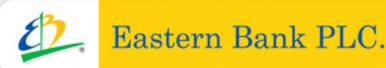

In [10]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [11]:
%pip install -Uq langchain-groq

In [12]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [13]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.3-70b-versatile")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [14]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 1})

In [19]:
text_summaries

['Bangladesh faced significant socio-political and macroeconomic challenges in July-August 2024, including a downgrade in its sovereign rating, but Eastern Bank Limited (EBL) has defied these odds with 32 years of remarkable growth, driven by sound governance, compliance culture, and prudent risk management, and is poised to navigate the uncharted path ahead with its trademark resilience and enterprising spirit.',
 "The document appears to be an annual report of a bank, Eastern Bank Limited (EBL), covering organizational overview, stewardship, and governance reports, including chairman's message, managing director's review, financial reports, and compliance with corporate governance guidelines and regulatory statutes.",
 'The provided text appears to be a table of contents for a comprehensive financial report, covering various aspects such as financial highlights, risk management, integrated reporting, and stakeholder information, with page numbers ranging from 69 to 256.',
 "The provi

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [20]:
%pip install -Uq langchain_openai

In [25]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import base64
from io import BytesIO

# Load an alternative BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

def get_image_summary_blip(base64_image: str) -> str:
    """
    Decodes a base64 image, processes it with BLIP, and returns a summary.
    """
    try:
        # Decode base64 image
        image_data = base64.b64decode(base64_image)
        image = Image.open(BytesIO(image_data)).convert("RGB")

        # Prepare inputs for BLIP
        # You can modify the prompt here if needed
        inputs = processor(image, "Describe the image in detail", return_tensors="pt").to(device)

        # Generate caption
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=128)

        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error processing image for summary with BLIP: {e}")
        return "Could not generate image summary."


image_summaries = [] # Initialize image_summaries
try:
    # Generate summaries for all images
    image_summaries = [get_image_summary_blip(img) for img in images]
except Exception as e:
    print(f"An error occurred during batch image summary generation: {e}")
    image_summaries = None # Set to None to indicate failure

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [26]:
image_summaries

['describe the image in detail of the logo',
 'describe the image in detail of the text',
 'describe the image in detail, the text in the image is in the form of a dove',
 'describe the image in detail below the text',
 'describe the image in detail below the text',
 'describe the image in detail below the text',
 'describe the image in detail of the letter of transmita',
 'describe the image in detail below the numbers of the most common and least index index index index index index index index index index index index index index',
 'describe the image in detail below the number of the data',
 'describe the image in detail below the numbers of the total and total numbers of the total and total numbers of the total and total numbers of the',
 'describe the image in detail to the number of the numbers',
 'describe the image in detail of the forest',
 'describe the image in detail of the geo map',
 'describe the image in detail to the text',
 'describe the image in detail below the numbe

In [27]:
print(image_summaries[1])

describe the image in detail of the text


## Load data and summaries to vectorstore

### Create the vectorstore

In [28]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/tmp/ipython-input-28-278287695.py:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/tmp/ipython-input-28-278287695.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
ERROR:chromadb.telemetry.product.p

### Load the summaries and link the to the original data

In [29]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
#retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
if image_summaries is not None:
    img_ids = [str(uuid.uuid4()) for _ in images]
    summary_img = [
        Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
    ]
    retriever.vectorstore.add_documents(summary_img)
    retriever.docstore.mset(list(zip(img_ids, images)))
else:
    print("Skipping image summary loading due to previous error.")

### Check retrieval

In [30]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


In [31]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIoBbIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0PHeo2cngUySVhwAcURknqKAJNwC+9APNMYHNKOlAErcrxUWW6Uqsc89KfkYoAaoweakOAMZpgPPNI4zzQAvyilVTnNRhSRmnbiqUAO3gNTupyKiC7zmplIAxQA12O3FRq+DzUjDmonT0oAViWcEU5yRigcAUNyRQAm4mnBuc

## RAG pipeline

In [35]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [37]:
response = chain.invoke(
    "What is EBL about?"
)

print(response)

Eastern Bank Limited (EBL) is a financial institution based in Bangladesh that offers a wide range of banking services. It provides services to both corporate clients and individuals, focusing on customized financial solutions for large and mid-corporate clients, particularly in sectors such as Ready-Made Garments (RMG), pharmaceuticals, telecommunications, and food industries.

EBL's core offerings include:

1. **Corporate Banking**: Services such as term lending, project financing, working capital financing, trade financing, cash management solutions, syndication, and advisory services.

2. **Retail & SME Banking**: A diverse portfolio targeting household clients and small and medium enterprises, including retail and SME deposits, personal and SME financing, student banking products, various card services, digital banking services, and payroll banking solutions.

3. **Treasury Services**: Management of fund, cash flow, liquidity, and overall asset-liability, as well as investing in s

In [38]:
response = chain_with_sources.invoke(
    "Who are EBL's biggest partners in tech?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The context does not explicitly mention specific technology partners for Eastern Bank PLC (EBL). However, it does highlight partnerships such as EBL's collaboration with JP Morgan to boost inward remittance and mentions various awards related to innovation and digital services, which may imply a reliance on advanced technology and potential partnerships in that sector. Further details about specific tech partners are not provided.


Context:
Digital CX Award

EBL Connect has won the “Outstanding Digital CX – Cash Management Platform 2024” award from The Digital Banker at the Digital CX Awards 2024. It is the world’s only program dedicated to recognizing pioneering innovation in digital customer experience across the financial services sector.

IFC Awards

In 2021 EBL was awarded by International Finance Corporation (IFC) under World Bank Group as the Best Partner for Equipment Trade in South Asia under Global Trade Finance Program.

IFC of World Bank group recognized EBL as t

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)